In [1]:
from train import *
from model import *
from helpers import *


import os
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
import torchvision
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

In [2]:
# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 128 x 128 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=GPU)

Using cache found in /home/hangdong/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/PGAN/celebaHQ16_december_s7_i96000-9c72988c.pth" to /home/hangdong/.cache/torch/checkpoints/celebaHQ16_december_s7_i96000-9c72988c.pth



Average network found !


In [3]:
dir(model)

['ClassificationCriterion',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'addScale',
 'avgG',
 'buildAvG',
 'buildNoiseData',
 'buildNoiseDataWithConstraints',
 'classificationPenalty',
 'config',
 'device',
 'getNetD',
 'getNetG',
 'getOptimizerD',
 'getOptimizerG',
 'getOriginalD',
 'getOriginalG',
 'getSize',
 'getStateDict',
 'initializeClassificationCriterion',
 'load',
 'load_state_dict',
 'lossCriterion',
 'n_devices',
 'netD',
 'netG',
 'optimizeParameters',
 'optimizerD',
 'optimizerG',
 'save',
 'test',
 'trainTmp',
 'updateAlpha',
 'updateConfig',
 'updateSolversDevice',
 'useGPU']

In [4]:
num_of_val = 24
code_dim = 512
z = np.random.normal(size=(1, code_dim)).astype(np.float32) # (1, 512)
z = torch.tensor(z, requires_grad=True).type(dtype)

torch.Size([1, 3, 128, 128])


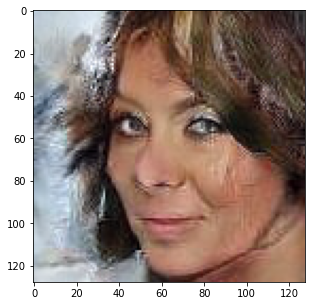

In [5]:
# plot
netG = model.netG
with torch.no_grad():
    out = netG(z)

grid = torchvision.utils.make_grid(out.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.figure(figsize=(14, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
print(out.shape)

In [6]:
# torch.save(netG.state_dict(), "./low_shots_celeb/checkpoint/gan_netG.pt")
# for p in netG.parameters():
#     print(p)

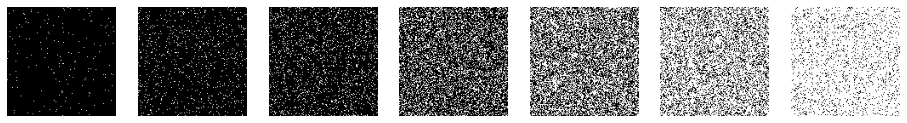

In [8]:
code_dim = 512
image_size = 128

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).type(dtype)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [9]:
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))
# validate images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(24, 44, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [10]:
LV_z = latent_var(z[0]).type(dtype)

netG = model.netG
for p in netG.parameters():
    p.requires_grad = False
    
g = CombinedNets(LV_z, netG).type(dtype)
optimizer = torch.optim.Adam(g.parameters(), lr=1e-2)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_trainable_parameters(g))
print(g)

512
CombinedNets(
  (Z): latent_var()
  (Decoder): DataParallel(
    (module): GNet(
      (scaleLayers): ModuleList(
        (0): ModuleList(
          (0): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): ModuleList(
          (0): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (2): ModuleList(
          (0): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): EqualizedConv2d(
            (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [18]:
# visual exam only
mask = masks[4].type(dtype)
loss_fn = nn.MSELoss()

n_epochs = 4000

# fit one image
def fit_img(n_epochs,
        net,
        img_idx,
        optimizer,
        mask,
        img_noisy_var,
        img_clean_var
       ):
    
    net.train()
    # training..
    for epoch in range(1, n_epochs+1):
        losses = []

        G_z = net([0])

        # inverse problems
        loss = loss_fn(G_z * mask, img_noisy_var) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        if epoch % 1000 == 0:
            print('val: {}, epoch: {} \t average loss: {:.6f}'.format(img_idx, epoch, np.mean(losses[-199:])))

    return z, G_z, psnr(img_clean_var.cpu().numpy(), G_z.detach().cpu().numpy())

In [19]:
for img_clean_var, _, img_list in val_loader:
    img_clean_var = Variable(img_clean_var).type(dtype)
    img_noisy_var = (img_clean_var * mask).type(dtype)
    z_, G_z_, snr = fit_img(n_epochs, g, img_list, optimizer, mask, img_noisy_var, img_clean_var)
    break

val: tensor([0]), epoch: 1000 	 average loss: 0.003724
val: tensor([0]), epoch: 2000 	 average loss: 0.002958
val: tensor([0]), epoch: 3000 	 average loss: 0.002553
val: tensor([0]), epoch: 4000 	 average loss: 0.002333


In [24]:
# visual results for inpainting task
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

def plot_all(plt, i):
    img_val, _, _ = val_set[i]
    img_val = img_val.type(dtype)
    
    fig = plt.figure(figsize = (15,15)) 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1, img_val)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2, img_val * mask)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_val.cpu().numpy(), (img_val.cpu().numpy() * mask.cpu().numpy())))
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3, G_z_)
    ax3.set_title( "Recovered image, PSNR: %.2f" % psnr(img_val.cpu().numpy(), G_z_.detach().cpu().numpy()) ) 
    ax3.axis('off')

23.11768080976758


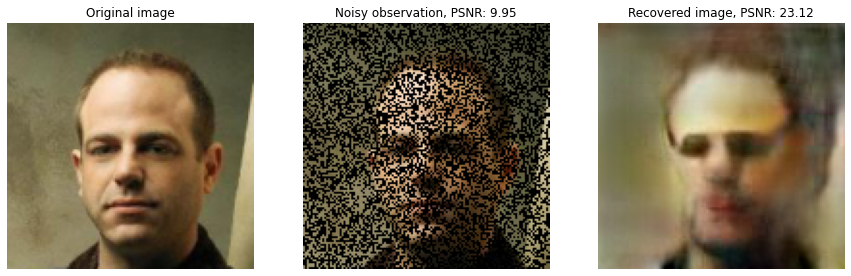

In [25]:
plot_all(plt, 0)
print(snr)

In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(g.parameters(), lr=5e-3)
n_epochs = 2000

psnr_list = np.zeros(num_of_val)
average_psnr = []

In [28]:
for ratio, mask in zip(ratios, masks):
    # for each mask
    print("for compression ratio:", ratio)
    
    # give a new batch of z
    z = np.random.normal(size=(num_of_val, 1, code_dim)).astype(np.float32) # (24, 1, 512)
    z = torch.tensor(z, requires_grad=True).type(dtype)
    
    for i, (img_clean_var, _, _) in enumerate(val_loader):
        progress = tqdm(total=1, desc='img % 3d' % i)
        
        # target image i
        img_clean_var = Variable(img_clean_var).type(dtype)
        img_noisy_var = (img_clean_var * mask).type(dtype)
        
        # build new net
        LV_z = latent_var(z[i]).type(dtype)
        netG = model.netG
        
        for p in netG.parameters():
            p.requires_grad = False
            
        net = CombinedNets(LV_z, netG).type(dtype)
        optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)

        # fit net, psnr record
        final_z, final_G_z, psnr_list[i] = fit_img(n_epochs, net, [i], optimizer, mask, img_noisy_var, img_clean_var)
        progress.set_postfix({'loss': loss_fn(final_G_z * mask, img_noisy_var).item()})
        progress.update()
        
    av_psnr = np.mean(psnr_list)
    average_psnr.append(av_psnr)
    print("average psnr = ", av_psnr)

for compression ratio: 0.01


val: [0], epoch: 1000 	 average loss: 0.000110
val: [0], epoch: 2000 	 average loss: 0.000061


val: [1], epoch: 1000 	 average loss: 0.000172
val: [1], epoch: 2000 	 average loss: 0.000104


val: [2], epoch: 1000 	 average loss: 0.000087
val: [2], epoch: 2000 	 average loss: 0.000055


val: [3], epoch: 1000 	 average loss: 0.000176
val: [3], epoch: 2000 	 average loss: 0.000119


val: [4], epoch: 1000 	 average loss: 0.000281
val: [4], epoch: 2000 	 average loss: 0.000205


val: [5], epoch: 1000 	 average loss: 0.000272
val: [5], epoch: 2000 	 average loss: 0.000165


val: [6], epoch: 1000 	 average loss: 0.000117
val: [6], epoch: 2000 	 average loss: 0.000079


val: [7], epoch: 1000 	 average loss: 0.000248
val: [7], epoch: 2000 	 average loss: 0.000183


val: [8], epoch: 1000 	 average loss: 0.000203
val: [8], epoch: 2000 	 average loss: 0.000121


val: [9], epoch: 1000 	 average loss: 0.000130
val: [9], epoch: 2000 	 average loss: 0.000071


val: [10], epoch: 1000 	 average loss: 0.000370
val: [10], epoch: 2000 	 average loss: 0.000224


val: [11], epoch: 1000 	 average loss: 0.000165
val: [11], epoch: 2000 	 average loss: 0.000119


val: [12], epoch: 1000 	 average loss: 0.000136
val: [12], epoch: 2000 	 average loss: 0.000089


val: [13], epoch: 1000 	 average loss: 0.000253
val: [13], epoch: 2000 	 average loss: 0.000126


val: [14], epoch: 1000 	 average loss: 0.000219
val: [14], epoch: 2000 	 average loss: 0.000101


val: [15], epoch: 1000 	 average loss: 0.000171
val: [15], epoch: 2000 	 average loss: 0.000068


val: [16], epoch: 1000 	 average loss: 0.000234
val: [16], epoch: 2000 	 average loss: 0.000163


val: [17], epoch: 1000 	 average loss: 0.000205
val: [17], epoch: 2000 	 average loss: 0.000131


val: [18], epoch: 1000 	 average loss: 0.000130
val: [18], epoch: 2000 	 average loss: 0.000100


val: [19], epoch: 1000 	 average loss: 0.000293
val: [19], epoch: 2000 	 average loss: 0.000178
average psnr =  11.853213875533413
for compression ratio: 0.05


val: [0], epoch: 1000 	 average loss: 0.000855
val: [0], epoch: 2000 	 average loss: 0.000679


val: [1], epoch: 1000 	 average loss: 0.001410
val: [1], epoch: 2000 	 average loss: 0.000970


val: [2], epoch: 1000 	 average loss: 0.000781
val: [2], epoch: 2000 	 average loss: 0.000385


val: [3], epoch: 1000 	 average loss: 0.001099
val: [3], epoch: 2000 	 average loss: 0.000759


val: [4], epoch: 1000 	 average loss: 0.001164
val: [4], epoch: 2000 	 average loss: 0.000848


val: [5], epoch: 1000 	 average loss: 0.001015
val: [5], epoch: 2000 	 average loss: 0.000702


val: [6], epoch: 1000 	 average loss: 0.001293
val: [6], epoch: 2000 	 average loss: 0.000880


val: [7], epoch: 1000 	 average loss: 0.001557
val: [7], epoch: 2000 	 average loss: 0.001127


val: [8], epoch: 1000 	 average loss: 0.001202
val: [8], epoch: 2000 	 average loss: 0.000854


val: [9], epoch: 1000 	 average loss: 0.000892
val: [9], epoch: 2000 	 average loss: 0.000554


val: [10], epoch: 1000 	 average loss: 0.001523
val: [10], epoch: 2000 	 average loss: 0.001194


val: [11], epoch: 1000 	 average loss: 0.001068
val: [11], epoch: 2000 	 average loss: 0.000839


val: [12], epoch: 1000 	 average loss: 0.000553
val: [12], epoch: 2000 	 average loss: 0.000440


val: [13], epoch: 1000 	 average loss: 0.001061
val: [13], epoch: 2000 	 average loss: 0.000800


val: [14], epoch: 1000 	 average loss: 0.002207
val: [14], epoch: 2000 	 average loss: 0.001403


val: [15], epoch: 1000 	 average loss: 0.001373
val: [15], epoch: 2000 	 average loss: 0.001023


val: [16], epoch: 1000 	 average loss: 0.001184
val: [16], epoch: 2000 	 average loss: 0.000721


val: [17], epoch: 1000 	 average loss: 0.000981
val: [17], epoch: 2000 	 average loss: 0.000802


val: [18], epoch: 1000 	 average loss: 0.001789
val: [18], epoch: 2000 	 average loss: 0.001273


val: [19], epoch: 1000 	 average loss: 0.002097
val: [19], epoch: 2000 	 average loss: 0.001713
average psnr =  13.728519518143544
for compression ratio: 0.1


val: [0], epoch: 1000 	 average loss: 0.002356
val: [0], epoch: 2000 	 average loss: 0.001669


val: [1], epoch: 1000 	 average loss: 0.002310
val: [1], epoch: 2000 	 average loss: 0.001490


val: [2], epoch: 1000 	 average loss: 0.001640
val: [2], epoch: 2000 	 average loss: 0.001030


val: [3], epoch: 1000 	 average loss: 0.003097
val: [3], epoch: 2000 	 average loss: 0.002442


val: [4], epoch: 1000 	 average loss: 0.001854
val: [4], epoch: 2000 	 average loss: 0.001497


val: [5], epoch: 1000 	 average loss: 0.002229
val: [5], epoch: 2000 	 average loss: 0.001554


val: [6], epoch: 1000 	 average loss: 0.002473
val: [6], epoch: 2000 	 average loss: 0.001498


val: [7], epoch: 1000 	 average loss: 0.004405
val: [7], epoch: 2000 	 average loss: 0.002214


val: [8], epoch: 1000 	 average loss: 0.002309
val: [8], epoch: 2000 	 average loss: 0.001639


val: [9], epoch: 1000 	 average loss: 0.002384
val: [9], epoch: 2000 	 average loss: 0.001843


val: [10], epoch: 1000 	 average loss: 0.002777
val: [10], epoch: 2000 	 average loss: 0.001573


val: [11], epoch: 1000 	 average loss: 0.002010
val: [11], epoch: 2000 	 average loss: 0.001573


val: [12], epoch: 1000 	 average loss: 0.001477
val: [12], epoch: 2000 	 average loss: 0.001166


val: [13], epoch: 1000 	 average loss: 0.001935
val: [13], epoch: 2000 	 average loss: 0.001510


val: [14], epoch: 1000 	 average loss: 0.004674
val: [14], epoch: 2000 	 average loss: 0.002913


val: [15], epoch: 1000 	 average loss: 0.001565
val: [15], epoch: 2000 	 average loss: 0.001138


val: [16], epoch: 1000 	 average loss: 0.002189
val: [16], epoch: 2000 	 average loss: 0.001157


val: [17], epoch: 1000 	 average loss: 0.001910
val: [17], epoch: 2000 	 average loss: 0.001272


val: [18], epoch: 1000 	 average loss: 0.003174
val: [18], epoch: 2000 	 average loss: 0.002129


val: [19], epoch: 1000 	 average loss: 0.002845
val: [19], epoch: 2000 	 average loss: 0.001997
average psnr =  14.570095953578948
for compression ratio: 0.3


val: [0], epoch: 1000 	 average loss: 0.006293
val: [0], epoch: 2000 	 average loss: 0.004193


val: [1], epoch: 1000 	 average loss: 0.007438
val: [1], epoch: 2000 	 average loss: 0.004801


val: [2], epoch: 1000 	 average loss: 0.010629
val: [2], epoch: 2000 	 average loss: 0.004709


val: [3], epoch: 1000 	 average loss: 0.006905
val: [3], epoch: 2000 	 average loss: 0.004311


val: [4], epoch: 1000 	 average loss: 0.006611
val: [4], epoch: 2000 	 average loss: 0.004641


val: [5], epoch: 1000 	 average loss: 0.005854
val: [5], epoch: 2000 	 average loss: 0.004491


val: [6], epoch: 1000 	 average loss: 0.006371
val: [6], epoch: 2000 	 average loss: 0.004533


val: [7], epoch: 1000 	 average loss: 0.006903
val: [7], epoch: 2000 	 average loss: 0.005526


val: [8], epoch: 1000 	 average loss: 0.006002
val: [8], epoch: 2000 	 average loss: 0.004444


val: [9], epoch: 1000 	 average loss: 0.006423
val: [9], epoch: 2000 	 average loss: 0.004196


val: [10], epoch: 1000 	 average loss: 0.007658
val: [10], epoch: 2000 	 average loss: 0.005831


val: [11], epoch: 1000 	 average loss: 0.007559
val: [11], epoch: 2000 	 average loss: 0.005042


val: [12], epoch: 1000 	 average loss: 0.004703
val: [12], epoch: 2000 	 average loss: 0.003476


val: [13], epoch: 1000 	 average loss: 0.009192
val: [13], epoch: 2000 	 average loss: 0.007197


val: [14], epoch: 1000 	 average loss: 0.009609
val: [14], epoch: 2000 	 average loss: 0.005173


val: [15], epoch: 1000 	 average loss: 0.003663
val: [15], epoch: 2000 	 average loss: 0.002442


val: [16], epoch: 1000 	 average loss: 0.007627
val: [16], epoch: 2000 	 average loss: 0.004589


val: [17], epoch: 1000 	 average loss: 0.008110
val: [17], epoch: 2000 	 average loss: 0.006317


val: [18], epoch: 1000 	 average loss: 0.009312
val: [18], epoch: 2000 	 average loss: 0.006326


val: [19], epoch: 1000 	 average loss: 0.009094
val: [19], epoch: 2000 	 average loss: 0.005880
average psnr =  14.820338355097254
for compression ratio: 0.5


val: [0], epoch: 1000 	 average loss: 0.008206
val: [0], epoch: 2000 	 average loss: 0.005818


KeyboardInterrupt: 